In [ ]:
#####################################
# In this homework, you will be training a simple network to classify the weather conditions
# while driving. Berkeley DeepDrive dataset, https://bdd-data.berkeley.edu/,
# contains a large amount of annotated driving data such as 2D bounding boxes, image
# segmentation, drivable areas and so on. You can read more about the dataset here,
# https://arxiv.org/pdf/1805.04687.pdf.

# 1. A code pushed in git(bitbucket).
# 2. A presentation video explaining the problem and results (duration must not be more
# than 10 mins); we will present this video for some groups in class.
#####################################

#####################################
# Homework Part 1: Download and unzip the dataset. (It’s a large dataset, so be aware about it). You’ll
# have to register an account and login to download the dataset.
#####################################

#####################################
# Homework Part 2: Understand how the dataset is managed, such as how each annotations correspond
# to its image etc. https://github.com/ucbdrive/bdd-data. They seperated the
# dataset by videos, labels, images etc.
#####################################

#####################################
# Homework Part 3: Build and train a Convolutional Neural Network (CNN) to correctly classify the
#correct weather attributes for a given image. Feel free to find suitable architectures/
#networks for inspiration, just make sure you cite where you get it from.
#– The training dataset provided have an imbalanced distribution of certain weather
#attribute as compared to others. Explore around to find the perfect balance of
#dataset to feed into your model.
#####################################

#####################################
# Homework Part 1-3 is adressed by the following code that build and trains a CNN neural network to clasify weather while driving
#####################################

In [105]:
#####################################
# importing the libraries
#####################################
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torchvision.models as models

# Other libraries 
import psutil
import gc
import time as tm
import os
import json
import ijson
import torch
from PIL import Image
import torchvision.transforms as transforms
import skimage
transform = transforms.Compose([transforms.PILToTensor()])

# Tensorflow libraries for onnx protocall buffer
import onnx
from onnx_tf.backend import prepare

In [21]:
#####################################
# Compute the maximum number of images that can fit on the GPU at once
#####################################
# clear pythorch gpu vairbles from cach
def clear_gpu_mem():
    try:
        del Xtrain
        del Xtest
        del Ytrain
        del Ytest
        gc.collect()
        torch.cuda.empty_cache() 
    except:
        pass

#print(torch.cuda.memory_summary(device=None, abbreviated=False))    

safty_factor=0.8
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # hard restetsall gpu memory
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '0:5120' # Sets max gpu memory allocation size
clear_gpu_mem()

gpu_memory_size = torch.cuda.get_device_properties(0).total_memory
print("GPU Memory Size in GB:", gpu_memory_size/10**9)

torch.cuda.empty_cache() # free unused memory,  only clears the cache of the GPU memory, not the model itself. 
free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
print("GPU free Memory  in GB:", free_mem/10**9)

image_size = 244* 244 * 3* 32   # # Define the size of each image (in bytes), image size * 3 RGB channels * precision 
max_images_gpu = int((free_mem / image_size) *safty_factor)
print("Max number of images that can theoretically on the GPU at once:", int(max_images_gpu/safty_factor))
print("Max number of images that can fit on the GPU safty factor:", max_images_gpu)

mem = psutil.virtual_memory() # Get SPU system memory 
available_ram = mem.available / (1024 ** 2) /1000 # Convert to GB
print('Available CPU RAM: GB', available_ram )

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Compute device:',device) # print device used

GPU Memory Size in GB: 8.585609216
GPU free Memory  in GB: 8.28228352
Max number of images that can theoretically on the GPU at once: 1448
Max number of images that can fit on the GPU safty factor: 1159
Available CPU RAM: GB 3.0773125
Compute device: cuda


In [22]:
#####################################
# Data Loader
#####################################
labelDir = 'bdd100k/labels/bdd100k_labels_images_train.json'
imagePath = 'bdd100k/images/100k/train/'
weatherAttributes = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'undefined']
labelOpen = open(labelDir)

# Define custom dataloader
class DataLoader():
    def __init__(self, lblDir, imgPath):
        self.lblDir = lblDir
        self.imgPath = imgPath
               
    def getSingleData(self, index):
        self.index = index
        lblopen = open(self.lblDir)
        recordCount = -1
        for record in ijson.items(lblopen, "item"):
            recordCount = recordCount + 1
            if recordCount == self.index:
                file = imagePath + record['name']
                label = record["attributes"]["weather"]
                break
        img = Image.open(file)
        img_tens = transform(img)
        return [img_tens, label]
    
    def obtainBatch(self, batchSize, batchNumber):
        self.batchSize = batchSize
        self.batchNumber = batchNumber
        lblopen = open(self.lblDir)
        imageBatch = []
        labelBatch = []
        recordCount = 0
        count = 0
        for record in ijson.items(lblopen, "item"):
            recordCount = recordCount + 1
            if recordCount > self.batchNumber*self.batchSize:
                # Load the image
                file = imagePath + record['name']               
                img = Image.open(file)
                
                # Resize the image
                img = img.resize((224, 224))  # Resize the image while NOT maintaining aspect ratio               
                #width, height = img.size
                #aspect_ratio = width / height
                #new_width = 224
                #new_height = int(new_width / aspect_ratio)                
                #img = img.resize((new_width, new_height)) # Resize the image while maintaining aspect ratio
                
                img_tens = transform(img) 
                imageBatch.append(img_tens)
                counter2 = -1
                for j in weatherAttributes:
                    counter2 = counter2 + 1
                    if record["attributes"]["weather"] == j:
                        labelBatch.append(counter2)
                        break
                        
                count = count + 1
                if count >= self.batchSize:
                    break
        imageSet = torch.stack(imageBatch)/255
        labelSet = torch.tensor(labelBatch, dtype = torch.long)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(imageSet, labelSet, test_size = 0.125, random_state = 0) 
        return [Xtrain, Xtest, Ytrain, Ytest]

    def obtainBatchfromLoad(self, batchSize, batchNumber, loadedFile, wthrAttributes):
        self.loadedFile = loadedFile
        self.batchSize = batchSize
        self.batchNumber = batchNumber
        self.wthrAttributes = wthrAttributes
        imageBatch = []
        labelBatch = []
        for i in range(self.batchSize):
            file = imagePath + self.loadedFile[self.batchNumber*self.batchSize + i]['name']
            img = Image.open(file)
            img_tens = transform(img)
            imageBatch.append(img_tens)
            for j in range(len(self.wthrAttributes)):
                if self.loadedFile[i]["attributes"]["weather"] == self.wthrAttributes[j]:
                    labelBatch.append(j)
                    break
        imageSet = torch.stack(imageBatch)/255
        labelSet = torch.tensor(labelBatch, dtype = torch.long)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(imageSet, labelSet, test_size = 0.125, random_state = 0)       
        return [Xtrain, Xtest, Ytrain, Ytest]

test_image = DataLoader(labelDir, imagePath).getSingleData(0)
print('Check clasification of one image:',test_image[1]) # print clasification of one image


Check clasification of one image: clear


In [23]:
#####################################
# Define the neural net architecture
#####################################
# Define the dimensions of the input images
img_width, img_height = 1280, 720
transformations = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# The input dimension for this CNN is a 4D tensor of shape (batch_size, channels, height, width), where:
# batch_size is the number of samples in each batch.
# channels is the number of input channels, which is set to 3 in the first layer to accommodate an RGB image, and it changes to 32 in the second layer, 64 in the third layer.
# height and width are the height and width of the input images, which can be of any size, but the padding and pooling layers' hyperparameters will adjust it.
# The output dimension is a 2D tensor of shape (batch_size, 7), which represents the output logits for the seven classes.

# load a pretrained nn
pretrained_model = models.resnet50(pretrained=True)#  Load the pre-trained CNN
modules = list(pretrained_model.children())[:-1] # Remove the fully connected layers
pretrained_model = nn.Sequential(*modules)
for param in pretrained_model.parameters(): # Freeze the pre-trained layers
    param.requires_grad = False
    
# Referances for pre trained model:
# Original Resnet50 paper : K. He, X. Zhang, S. Ren, and J. Sun, 2016, "Deep Residual Learning for Image Recognition," in Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 770-778       
# Studies show Resnet50 is good for  wheather clasification:
    # 1) 93.4% Accuracy- M. Wang, H. Liu, H. Zhang, Y. Zhang, and W. Zhang, 2020, "A deep learning approach for cloud classification based on satellite imagery," Journal of Atmospheric and Oceanic Technology, vol. 37, no. 3, pp. 523-536, Mar. 2020. DOI: 10.1175/JTECH-D-19-0084.1.
    # 2) 98.3% K. Zhang, L. Wang, and L. Zhang, 2021, "A Convolutional Neural Network Approach for Weather Recognition Based on Sky Images," International Journal of Advanced Computer Science and Applications, vol. 12, no. 5, pp. 324-330, May 2021. DOI: 10.14569/IJACSA.2021.0120549.    
    
# Define the neural network architecture
class CNN_class(nn.Module):  
    def __init__(self):
        super().__init__()
        # pre trained model
        self.pretrained_model = pretrained_model  
        
        # custom classifier
        self.classifier = nn.Sequential(
            
            # layer 1
            nn.Linear(2048, 1024)  ,
            nn.Dropout(p=0.1),
            nn.BatchNorm1d(1024), # applying batch norm before activation function
            nn.LeakyReLU(negative_slope=0.01),
            
            # layer 2
            nn.Linear(1024, 256) ,            
            nn.Dropout(p=0.1),
            nn.BatchNorm1d(256), # applying batch norm before activation function
            nn.LeakyReLU(negative_slope=0.01),
            
            # layer 3
            nn.Linear(256, 7),
            nn.Softmax(dim=1)  # batch of N images, where each image has C classes.  shape (N, C). softmax function is applied along the dim=1 (second) dimension, it normalizes the values along this dimension to ensure that they sum to 1, producing a probability distribution over the C,output tensor of the softmax function would have the same shape as the input tensor (N, C)                   
        )
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        #self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride = 1) ## First layer in loads a RGB image of shape 3x32 outputs 3
        #self.pool1 = nn.MaxPool2d([12,11])
        #self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride = 1)
        #self.pool2 = nn.MaxPool2d([13,7])
        #self.fc1 = nn.Linear(64 * 8 * 8 , 256)
        #self.dropout = nn.Dropout(p=0.4)
        #self.fc2 = nn.Linear(256, 7) ## Need to check output size matches number of labels        
        
        
    def forward(self, x):        
        # Extract features from pre-trained CNN
        features = self.pretrained_model(x)
        features = features.view(features.size(0), -1) 
        
        # Pass features through three fully connected layers   
        x= self.classifier(features)      
        return x
    
    def reset_weights(self):
        torch.manual_seed(1339)
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        return 



/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [115]:
#####################################
# Instantiate the CNN model and define the optimizer and loss function
#####################################
model = CNN_class() 
optimizer = optim.Adam(model.parameters(), lr=2*1e-4, weight_decay= 2*1e-3 )
loss_function = nn.CrossEntropyLoss()

# Move model to GPU if available
torch.cuda.empty_cache() 
model = model.to(device)
loss_function=loss_function.to(device)
print('device:',device)
print(model)

device: cuda
CNN_class(
  (pretrained_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [25]:
#####################################
# Train the model
#####################################
# training setup
specify_train_time=90 # [min]
n_epochs = 5
batch_size=  min(256, max_images_gpu)  # number of images to load per batch 
print('max num of images fit in the gpu at once:', max_images_gpu)
Estimated_time_per_batch = 7.5*batch_size/256 #  [sec]- Related to image batch size
print('Batch size:', batch_size)
images_in_dataset=69863
batches_in_datset= int(images_in_dataset/batch_size)-1
print('Batches_in_datset:',batches_in_datset) #8731
minibatches_per_epoch=min(int( (specify_train_time*60)/Estimated_time_per_batch/n_epochs), batches_in_datset-3)
print('Batches to run:', minibatches_per_epoch)
print('Images_in_dataset:', images_in_dataset)
print('Num Images used:', minibatches_per_epoch*batch_size)
print('Images use fraction out total dataset:', np.round(minibatches_per_epoch*batch_size/images_in_dataset,2))
print('n_epochs per batch:', n_epochs)
print(' ')

clear_gpu_mem() # clear gpu cach
model.reset_weights() # reset the model weights  
torch.manual_seed(1339)

# number of images in train: 69863, height of 720 pixels, width of 1280 pixels
labelDir = 'bdd100k/labels/bdd100k_labels_images_train.json'
imagePath = 'bdd100k/images/100k/train/'
weatherAttributes = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'undefined']
labelOpen = open(labelDir)


# start training loop
print('Start training loop:')
loss_train_list=[]
loss_test_list=[]
iteration_list=[]
accuracy_train_list=[]
accuracy_test_list=[]
iteration=0
t1=tm.time()
import time as tm
for epoch in range(0,n_epochs): # loops through whole dataset a set number of times 
    for i in range(0,minibatches_per_epoch): # loops through number of mini batches 
        iteration=iteration+1
        
        # load minibatch training and test data from dataloader 
        [Xtrain, Xtest, Ytrain, Ytest] = DataLoader(labelDir, imagePath).obtainBatch(batchSize=batch_size, batchNumber=i+1) 
       
        # move the tensors to the GPU if available, or to the CPU otherwise.
        Xtrain = Xtrain.to(device) 
        Xtest = Xtest.to(device)
        Ytrain = Ytrain.to(device)
        Ytest = Ytest.to(device)
        #Ytrain=F.one_hot(Ytrain, num_classes=7).float() # class index to one hot encoding
        #Ytest=F.one_hot(Ytest, num_classes=7).float() # class index to one hot encoding    
               
        # Calulate train loss
        model.train() # Evaluate model with dropout 
        optimizer.zero_grad()
        outputs_train = model.forward(Xtrain) # evaluates model outputs with training input data
        loss_train = loss_function(outputs_train, Ytrain) # model should softmax proabilities, targets can be either in the form of probabilities for each class (one-hot encoded) or class indices.
               
        # print the model outputs and labels 
        if iteration<=1: 
            print('Xtest_size:',Xtrain.size())
            print('Xtest_size:',Xtest.size()) 
            print('Ytrain_size:',Ytrain.size())
            print('Ytest_size:',Ytest.size()) 
            print('  ')
            print('Ytest_train:',outputs_train)
            print('Ytrain:', Ytrain)
            print('  ')
            
        # Calulate test loss        
        model.eval() # Evaluate model with dropout off
        with torch.no_grad():
            outputs_test = model.forward(Xtest) # evaluates model outputs with test data
            loss_test = loss_function(outputs_test,Ytest) # evaluates model loss vs actual labels
            
        # Calulate number correct in test and train
        _, predicted_train = torch.max(outputs_train.data, 1) # determine index of the correct categories        
        total_train = Ytrain.size(0)
        correct_train = (predicted_train == Ytrain).sum().item() # count number of correctly predicted 
        accuracy_train = 100 * correct_train / total_train           
        _, predicted_test = torch.max(outputs_test.data, 1) # determine index of the correct categories        
        total_test = Ytest.size(0)
        correct_test = (predicted_test == Ytest).sum().item() # count number of correctly predicted 
        accuracy_test = 100 * correct_test / total_test  
       
       
        # Run the optimiser one step
        loss_train.backward()                
        optimizer.step()  
        
        
        # Save iteration Data 
        loss_train_list.append(loss_train.detach().cpu().numpy()) 
        loss_test_list.append(loss_test.detach().cpu().numpy()) 
        iteration_list.append(iteration)
        accuracy_train_list.append(accuracy_train)
        accuracy_test_list.append(accuracy_test)
        
        # Print stats
        print_n=5
        if iteration % print_n == 0: 
            print('#############')
            print('Epoch:'+str(epoch+1),'/',n_epochs)           
            print('Minibatch Number:'+str(i+1),'/',minibatches_per_epoch)
            print('Iteration:'+str(iteration),'/',round(minibatches_per_epoch*n_epochs))
            print('loss_train', round(loss_train.item(),3))
            print('loss_test', round(loss_test.item(),3))           
            print('Avg time per bat1ch [s]:', round((tm.time()-t1)/print_n,2 ))
            print('Estimated training time remaing [min]:', round(((minibatches_per_epoch*n_epochs)-iteration)*((tm.time()-t1)/print_n) /60,1)) 
            print('accuracy_train',round(accuracy_train,2))
            print('accuracy_test',round(accuracy_test,2))
            print('#############')
            print(' ')
            t1=tm.time()
            
print('Training Done') 

# save the model
torch.save(model.state_dict(), 'my_model.pt')
# model.load_state_dict(torch.load(filename))
np.save('loss_train.npy', np.array(loss_train_list))
np.save('loss_test.npy', np.array(loss_test_list))
np.save('accuracy_train_list.npy', np.array(accuracy_train_list))
np.save('accuracy_test_list.npy', np.array(accuracy_test_list))
#loss_train = np.load('loss_train.npy')

max num of images fit in the gpu at once: 1159
Batch size: 256
Batches_in_datset: 271
Batches to run: 144
Images_in_dataset: 69863
Num Images used: 36864
Images use fraction out total dataset: 0.53
n_epochs per batch: 5
 
Start training loop:
Xtest_size: torch.Size([224, 3, 224, 224])
Xtest_size: torch.Size([32, 3, 224, 224])
Ytrain_size: torch.Size([224])
Ytest_size: torch.Size([32])
  
Ytest_train: tensor([[0.0881, 0.1450, 0.2128,  ..., 0.1145, 0.1591, 0.1732],
        [0.1025, 0.2331, 0.0807,  ..., 0.1539, 0.1519, 0.1570],
        [0.0999, 0.1279, 0.1271,  ..., 0.2355, 0.1032, 0.1616],
        ...,
        [0.0742, 0.1171, 0.1195,  ..., 0.2853, 0.0992, 0.1862],
        [0.1006, 0.1353, 0.0935,  ..., 0.2041, 0.1046, 0.2279],
        [0.1354, 0.1741, 0.1165,  ..., 0.1671, 0.0949, 0.1583]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Ytrain: tensor([0, 0, 2, 6, 0, 3, 4, 6, 0, 6, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 2, 2, 0, 2,
        0, 5, 4, 2, 0, 5, 0, 0, 2, 2, 3, 0, 0, 4, 0, 2, 0,

Batch size: 256
Images trained on: 36864


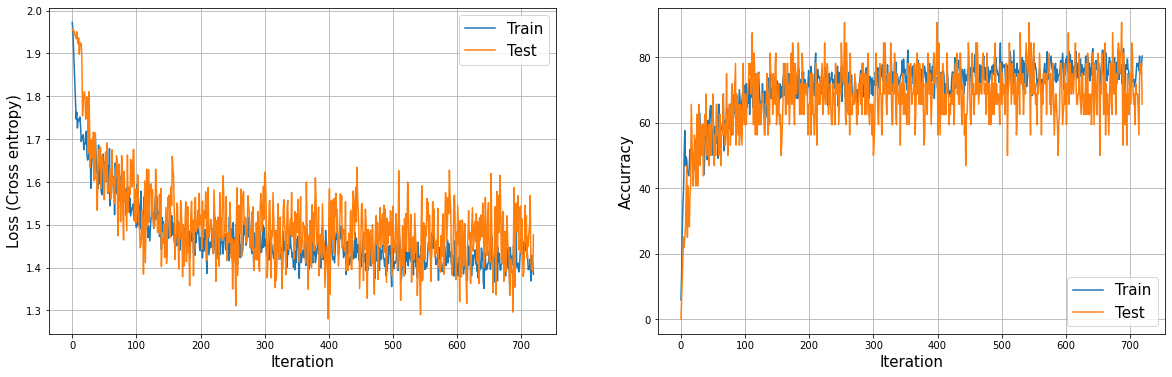

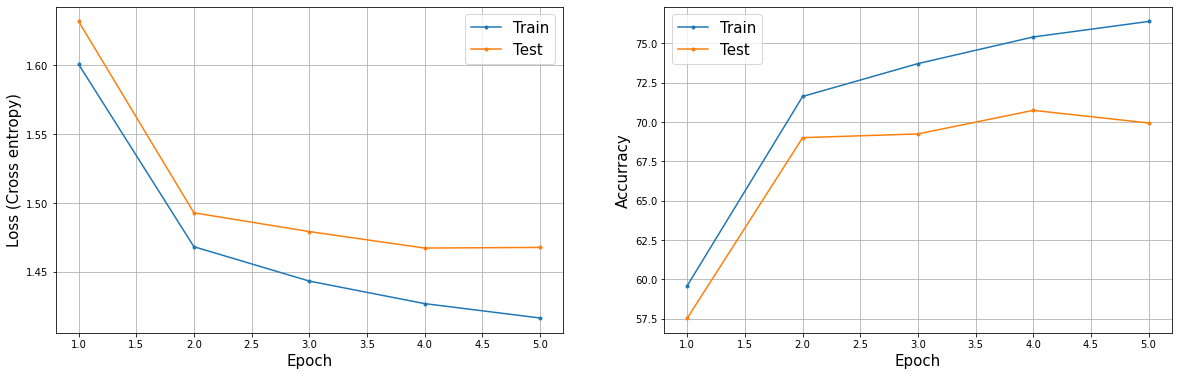

In [48]:
#####################################
## Plot training and test loss & Accuracy
#####################################
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
iteration_list=np.arange(0,len(loss_train_list))
ax1.plot(iteration_list,loss_train_list,label='Train')
ax1.plot(iteration_list,loss_test_list,label='Test')
ax1.set_xlabel('Iteration',fontsize=15)
ax1.set_ylabel('Loss (Cross entropy)',fontsize=15)
ax1.legend(fontsize=15)
ax1.grid()

ax2.plot(iteration_list,accuracy_train_list,label='Train')
ax2.plot(iteration_list,accuracy_test_list,label='Test')
ax2.set_xlabel('Iteration',fontsize=15)
ax2.set_ylabel('Accurracy',fontsize=15)
ax2.legend(fontsize=15)
ax2.grid()

# sum over iteration for epoch average
print('Batch size:', batch_size)
print('Images trained on:', minibatches_per_epoch*batch_size)
epoch_loss_train=[]
epoch_loss_test=[]
epoch_accuracy_train=[]
epoch_accuracy_test=[]
idx=np.arange(0, minibatches_per_epoch*(n_epochs+1), minibatches_per_epoch)
for i in range(0,n_epochs):
    # Compute the average loss and accuracy for the current epoch
    avg_loss_train = np.mean(loss_train_list[idx[i]:idx[i+1]]) 
    avg_loss_test = np.mean(loss_test_list[idx[i]:idx[i+1]]) 
    avg_acc_train = np.mean(accuracy_train_list[idx[i]:idx[i+1]]) 
    avg_acc_test = np.mean(accuracy_test_list[idx[i]:idx[i+1]]) 
    
    # Add the averages to the epoch arrays
    epoch_loss_train.append(avg_loss_train)
    epoch_loss_test.append(avg_loss_test)
    epoch_accuracy_train.append(avg_acc_train)
    epoch_accuracy_test.append(avg_acc_test) 
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
iteration_list=np.arange(1,n_epochs+1)
ax1.plot(iteration_list,epoch_loss_train,'.-',label='Train')
ax1.plot(iteration_list,epoch_loss_test,'.-',label='Test')
ax1.set_xlabel('Epoch',fontsize=15)
ax1.set_ylabel('Loss (Cross entropy)',fontsize=15)
ax1.legend(fontsize=15)
ax1.grid()

ax2.plot(iteration_list,epoch_accuracy_train,'.-',label='Train')
ax2.plot(iteration_list,epoch_accuracy_test,'.-',label='Test')
ax2.set_xlabel('Epoch',fontsize=15)
ax2.set_ylabel('Accurracy',fontsize=15)
ax2.legend(fontsize=15)
ax2.grid()

 #######################
 Inferance on 20 random images in training set:
Predictions:  tensor([6, 4, 0, 0, 0, 5, 0, 0, 6, 0, 2, 0, 5, 0, 0, 6, 0, 0, 6, 0],
       device='cuda:0')
Actual weather attributes:  tensor([6, 5, 0, 6, 0, 5, 0, 4, 5, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0],
       device='cuda:0')
 #######################
   


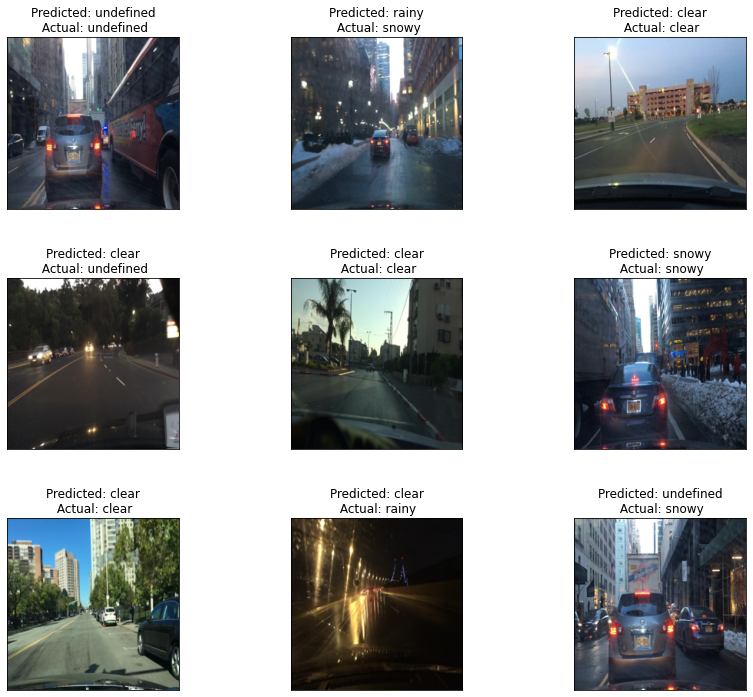

   
 #######################
 Inferance on 20 random images in test set:
Predictions:  [6 0 4 0 2 2 4 0 0 0 6 6 0 5 6 0 0 0 2 0]
Actual weather attributes:  [6 0 4 0 2 2 4 0 0 0 6 6 0 5 6 0 0 0 2 0]
 #######################


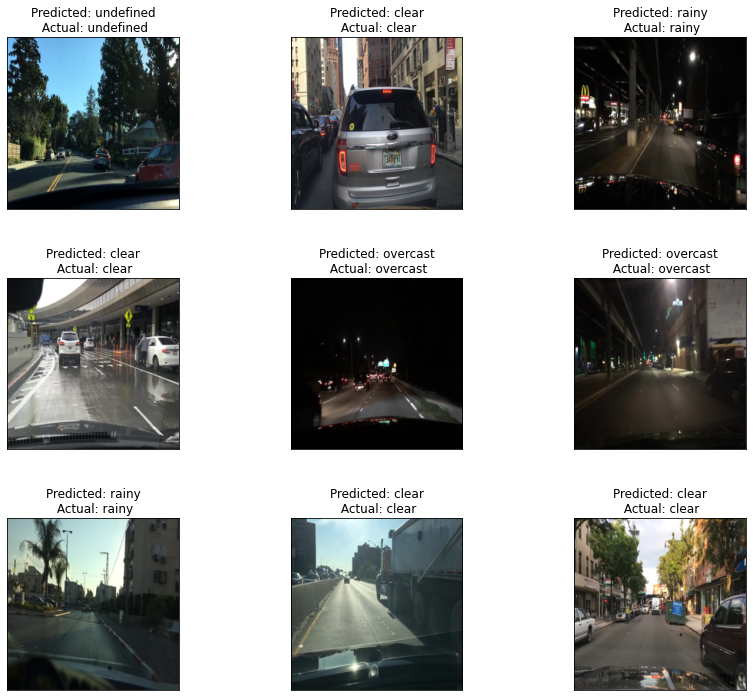

In [99]:
#####################################
# Homework Part 4: Run an inference on the test dataset provided with your best performing model.
# You can even show how well your model perform on your own driving images (not from BDD).
#####################################
def get_weather_label(class_index):
    weather_classes = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'undefined']    
    return str(weather_classes[class_index])

# Get data & Run model for training set
[Xtrain, Xtest, Ytrain, Ytest] = DataLoader(labelDir, imagePath).obtainBatch(23, 0)
Xtrain = Xtrain.to(device) 
Ytrain = Ytrain.to(device)
output_train = model(Xtrain)
_,class_predictions = torch.max(output_train.data, 1)
class_actual=Ytrain

print(' #######################')
print(" Inferance on 20 random images in training set:")
print("Predictions: ", class_predictions)
print("Actual weather attributes: ", class_actual)
print(' #######################')
print('   ')

# Plot actual images for training set
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.subplots_adjust(wspace=0.05, hspace=0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtrain[i].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title('Predicted: '+get_weather_label(class_predictions[i])+'\n Actual: '+get_weather_label(class_actual[i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0)
plt.show()


# Get data & Run model for test set
[Xtrain, Xtest, Ytrain, Ytest] = DataLoader(labelDir, imagePath).obtainBatch(batch_size, 0)
Xtest = Xtest.to(device)
Ytest = Ytest.to(device)
output_test = model(Xtest)
_,class_predictions = torch.max(output_test.data, 1)
class_actual=Ytest
class_predictions=class_predictions.cpu().numpy()[0:20]
class_actual=np.array(class_predictions[0:20])

print('   ')
print(' #######################')
print(" Inferance on 20 random images in test set:")
print("Predictions: ", class_predictions)
print("Actual weather attributes: ", class_actual)
print(' #######################')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.subplots_adjust(wspace=0.05, hspace=0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(Xtrain[i].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title('Predicted: '+get_weather_label(class_predictions[i])+'\n Actual: '+get_weather_label(class_actual[i]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0)
plt.show()



In [120]:
#####################################
# Homework part 5: Convert the trained model with weights to a frozen model and save it as a Protocol
# Buffer. Read about ONNX.
#####################################
# Code description: Convert a PyTorch model to a frozen ONNX (Open Neural Network Exchange) model and saves it. 
# Then the model opened using TensorFlow and saved as a Protocol Buffer.

# model.load_state_dict(torch.load('my_model.pt')) # Load saved pytorch model

# Export the pytorch model to ONNX format
model.to(device) # Move the model to GPU
dummy_input = torch.randn(1, 3, 224, 224) # Create a dummy input
dummy_input = dummy_input.to(device)
input_names = ["input"]
output_names = ["output"]
torch.onnx.export(model, dummy_input, "model_onnx.onnx", input_names=input_names, output_names=output_names)

# Convert the onnx model to a frozen Tensorflow model and save it as a Protocol Buffer file .pb
model_tf = onnx.load("model_onnx.onnx")
tf_model = prepare(model_tf)
tf_model.export_graph("frozen_protocall_buffer_model.pb")

print(' ')
print('#####################################')
print("Model successfully saved as a frozen Protocol Buffer!")
print('#####################################')

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



INFO:tensorflow:Assets written to: frozen_protocall_buffer_model.pb/assets


INFO:tensorflow:Assets written to: frozen_protocall_buffer_model.pb/assets


 
#####################################
Model successfully saved as a frozen Protocol Buffer!
#####################################
